# **MAI3004 - Team Resistance (Rebekka)**



Cleo Habets - i6337758

Ketlin Marku - i6345996

Thora Priester - i6346891

Bjørn Rejhons - i6324753


# **Project description**

**Prediction of antimicrobial resistance based on whole-genome sequencing and machine learning**

---



Antimicrobial resistance (AMR) is one of the biggest global problems threatening human and animal health. Rapid and accurate AMR diagnostic methods are thus very urgently needed. However, traditional antimicrobial susceptibility testing (AST) is time-consuming, low throughput, and viable only for cultivable bacteria. Machine learning methods may pave the way for automated AMR prediction based on genomic data of the bacteria. However, comparing different machine learning methods for the prediction of AMR based on different encodings and whole-genome sequencing data without previously known knowledge remains to be done.

In the current study, we evaluated logistic regression (LR), support vector machine (SVM), random forest (RF), and convolutional neural network (CNN) for the prediction of AMR for the antibiotics ciprofloxacin (CIP), cefotaxime (CTX), ceftazidime (CTZ), and gentamicin (GEN) based on WGS data with label encoding and FCGR encoding.


---
**OUR TEAM REPRODUCED THIS RESEARCH**


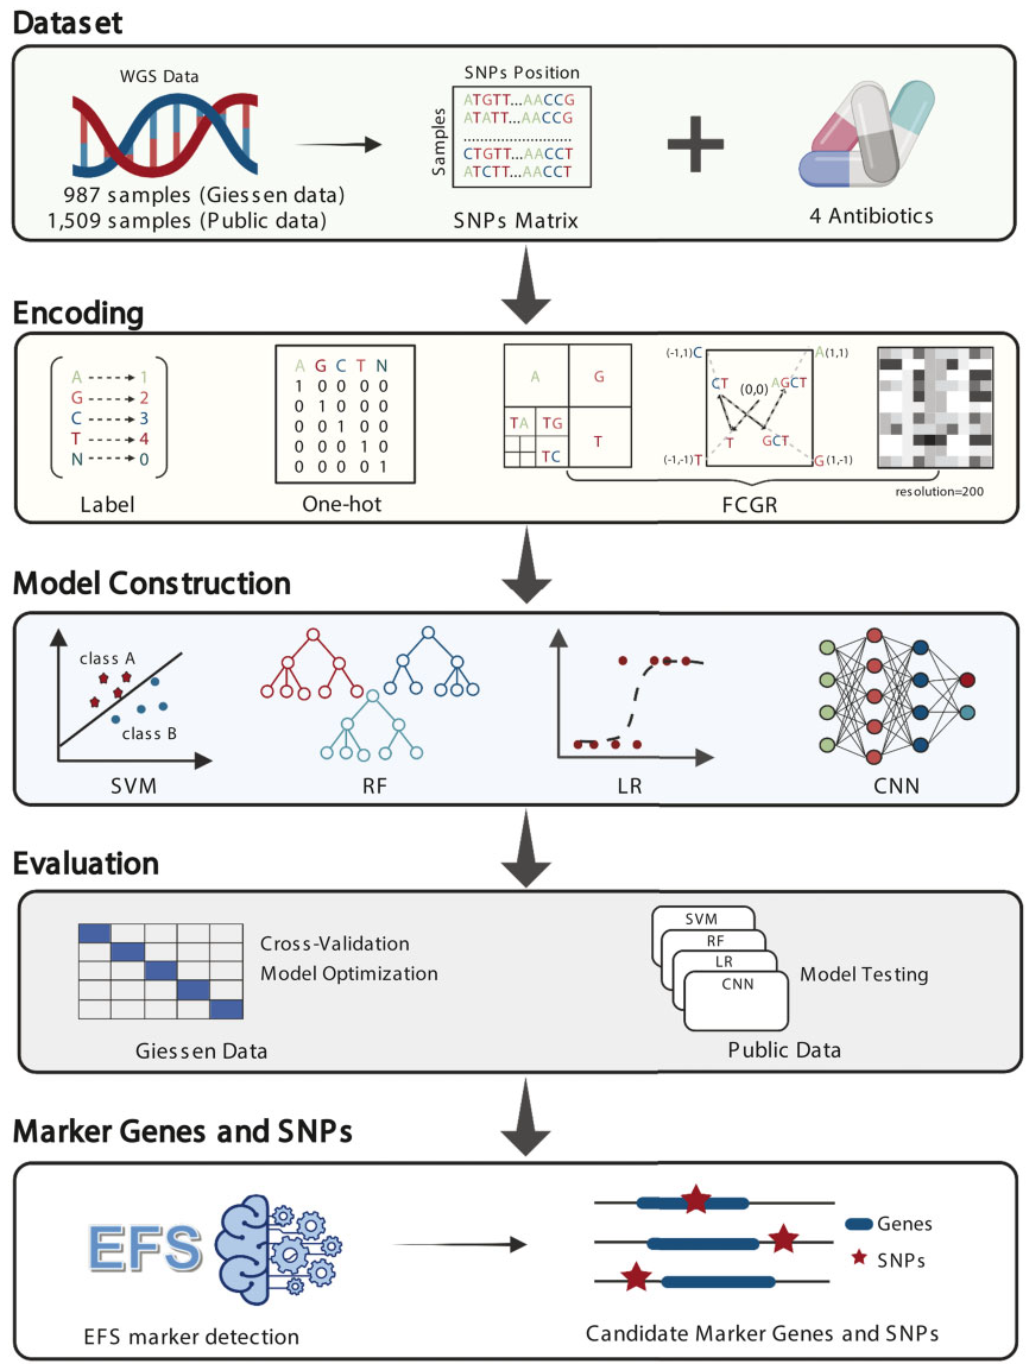



# **Libraries**

In [ ]:
# Basic libraries
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

# Machine learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier # For baseline/ comparison model
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
# Still need to import SVM etc..
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras


# **The *metadata* dataset**

In [ ]:
# Loading the dataset
metadata = pd.read_csv("/content/metadata.csv")

In [ ]:
metadata.head()

,Name,Date_of_Birth,Address,Species,Sample_ID,Ciprofloxacin,Cefotaxime,Ceftazidime,Gentamicin,Cipro,Cefo,Ceftaz,Gent
0,Megan Williams,2003-11-29,"9961 Jones Mills, Europa Colony",Ecoli,H100_S2_L001,S,R,S,S,NaN,NaN,NaN,NaN
1,Justin Moran,1988-09-24,"697 Chavez Ways Suite 512, Ganymede Complex",Ecoli,H105_S3_L001,R,R,S,S,NaN,NaN,NaN,NaN
2,Fred Martin,1965-06-01,"070 Price Village, Titan Outpost",Ecoli,H108_S5_L001,S,R,S,S,NaN,NaN,NaN,NaN
3,Brandon Campbell,1946-08-01,"628 Brown Rest, Venus Dome",Ecoli,H109_S2_L001,S,R,S,S,NaN,NaN,NaN,NaN
4,Charles Jefferson,1982-12-30,"7413 Jenny Knoll, Luna Base",Ecoli,H113_S6_L001,R,R,S,S,NaN,NaN,NaN,NaN


In [ ]:
metadata.shape

(813, 13)

## **Preprocessing - Data cleaning**

**Preprocessing pipeline**
* **Remove duplicate dample IDs**: Remove duplicate 'Sample_ID'
entries from the metadata, keeping the first occurrence to ensure unique identifiers for each sample.
* **Standardize antibiotic labels**: Standardize the values in the antibiotic columns to 'S' (Susceptible) and 'R' (Resistant) for consistency.
* **Remove columns** due to privacy.
* **Handle synonymous columns**: Consolidate data from abbreviated antibiotic columns (e.g., 'Cipro') into their full-name counterparts (e.g., 'Ciprofloxacin') where values are missing, and then remove the redundant abbreviated columns.
* **Binary encode antibiotic columns**: Convert the 'S' and 'R' labels in the final antibiotic columns into binary numerical values (0 for 'S' and 1 for 'R').

### **Unique IDs**

In [ ]:
#Metadata ID is not unique?
metadata["Sample_ID"].is_unique

False

In [ ]:
metadata["Sample_ID"].nunique()

812

So, 1 Sample ID is duplicate

In [ ]:
# Identifying rows where the Sample_ID is a duplicate
duplicates = metadata[metadata.duplicated(subset=['Sample_ID'], keep=False)]

print(f"Number of duplicate IDs: {len(duplicates)}")
duplicates

Number of duplicate IDs: 2


,Name,Date_of_Birth,Address,Species,Sample_ID,Ciprofloxacin,Cefotaxime,Ceftazidime,Gentamicin,Cipro,Cefo,Ceftaz,Gent
299,Brandon Khan,1988-02-04,"688 Jordan Shoals Apt. 479, Titan Outpost",Ecoli,RBk-18-0216-1_S231_2,s,S,S,S,NaN,NaN,NaN,NaN
300,Brandon Khan,1988-02-04,"688 Jordan Shoals Apt. 479, Titan Outpost",Ecoli,RBk-18-0216-1_S231_2,S,S,S,S,NaN,NaN,NaN,NaN


In [ ]:
# Removing the duplicate Sample_ID, keeping only the first occurrence
metadata = metadata.drop_duplicates(subset=['Sample_ID'], keep='first')

# Verifying that the duplicate is gone (should return 0)
print(f"Remaining duplicates: {metadata.duplicated(subset=['Sample_ID']).sum()}")

Remaining duplicates: 0


### **Standardizing labels**

In [ ]:
# List of columns we want to clean to ensure consistency
antibiotics = ['Ciprofloxacin', 'Cefotaxime', 'Ceftazidime', 'Gentamicin', 'Cipro', 'Cefo',	'Ceftaz',	'Gent' ]

# Defining how to map the messy values
mapping = {
    'Susceptible': 'S',
    's': 'S',
    'Resistant': 'R',
    'r': 'R'
}

# Apply the change to all columns in the list
for col in antibiotics:
    metadata[col] = metadata[col].replace(mapping)

In [ ]:
# Check for every column if it worked
print(metadata.Ciprofloxacin.value_counts())
print(metadata.Cipro.value_counts())

Ciprofloxacin
S    420
R    342
Name: count, dtype: int64
Cipro
R    25
S    25
Name: count, dtype: int64


In [ ]:
print(metadata.Cefotaxime.value_counts())
print(metadata.Cefo.value_counts())

Cefotaxime
S    454
R    308
Name: count, dtype: int64
Cefo
R    50
Name: count, dtype: int64


In [ ]:
print(metadata.Ceftazidime.value_counts())
print(metadata.Ceftaz.value_counts())

Ceftazidime
S    533
R    229
Name: count, dtype: int64
Ceftaz
R    50
Name: count, dtype: int64


In [ ]:
print(metadata.Gentamicin.value_counts())
print(metadata.Gent.value_counts())

Gentamicin
S    591
R    171
Name: count, dtype: int64
Gent
S    32
R    18
Name: count, dtype: int64


### **Dropping columns**

In [ ]:
# Checking if it is just Ecoli, so we can remove this column.
metadata.Species.nunique()

1

In [ ]:
# Creating a copy of the original dataframe
metadata_relevant_columns = metadata.copy()

# Dropping the specific columns for privacy and redundancy
columns_to_remove = ['Name', 'Date_of_Birth', 'Address', 'Species']
metadata_relevant_columns = metadata_relevant_columns.drop(columns=columns_to_remove)

# Verifying the change
print(f"Original shape: {metadata.shape}")
print(f"New shape: {metadata_relevant_columns.shape}")
metadata_relevant_columns.head()

Original shape: (812, 13)
New shape: (812, 9)


,Sample_ID,Ciprofloxacin,Cefotaxime,Ceftazidime,Gentamicin,Cipro,Cefo,Ceftaz,Gent
0,H100_S2_L001,S,R,S,S,NaN,NaN,NaN,NaN
1,H105_S3_L001,R,R,S,S,NaN,NaN,NaN,NaN
2,H108_S5_L001,S,R,S,S,NaN,NaN,NaN,NaN
3,H109_S2_L001,S,R,S,S,NaN,NaN,NaN,NaN
4,H113_S6_L001,R,R,S,S,NaN,NaN,NaN,NaN


### **Missing values**

In [ ]:
metadata.isnull().sum()

,0
Name,0
Date_of_Birth,0
Address,0
Species,0
Sample_ID,0
Ciprofloxacin,50
Cefotaxime,50
Ceftazidime,50
Gentamicin,50
Cipro,762


### **Handling the synonymous columns**

In [ ]:
# List of synonymous columns (Full Name, Abbreviation)
synonymous_columns = [
    ('Ciprofloxacin', 'Cipro'),
    ('Cefotaxime', 'Cefo'),
    ('Ceftazidime', 'Ceftaz'),
    ('Gentamicin', 'Gent')
]

for full, abbr in synonymous_columns:
    missing_full = metadata_relevant_columns[full].isnull().sum()
    missing_abbr = metadata_relevant_columns[abbr].isnull().sum()
    print(f"{full} missing: {missing_full} | {abbr} missing: {missing_abbr}")

Ciprofloxacin missing: 50 | Cipro missing: 762
Cefotaxime missing: 50 | Cefo missing: 762
Ceftazidime missing: 50 | Ceftaz missing: 762
Gentamicin missing: 50 | Gent missing: 762


All of the missing values in the full name columns, are values in the abbreviation columns and vice versa.

In [ ]:
# Filling in missing values in the full column using the abbreviation column
for full, abbr in synonymous_columns:
    metadata_relevant_columns[full] = metadata_relevant_columns[full].fillna(metadata_relevant_columns[abbr])

In [ ]:
metadata_relevant_columns

,Sample_ID,Ciprofloxacin,Cefotaxime,Ceftazidime,Gentamicin,Cipro,Cefo,Ceftaz,Gent
0,H100_S2_L001,S,R,S,S,NaN,NaN,NaN,NaN
1,H105_S3_L001,R,R,S,S,NaN,NaN,NaN,NaN
2,H108_S5_L001,S,R,S,S,NaN,NaN,NaN,NaN
3,H109_S2_L001,S,R,S,S,NaN,NaN,NaN,NaN
4,H113_S6_L001,R,R,S,S,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
808,Survcare341_S25,R,R,R,S,R,R,R,S
809,Survcare350_S44,R,R,R,S,R,R,R,S
810,Survcare360_S84,R,R,R,S,R,R,R,S
811,wdh-Survcare119_S44,S,R,R,S,S,R,R,S


In [ ]:
# List of abbreviation columns to be removed
abbr_cols = ['Cipro', 'Cefo', 'Ceftaz', 'Gent']

# Dropping the abbreviation columns
metadata_cleaned = metadata_relevant_columns.drop(columns=abbr_cols)

In [ ]:
# Check
metadata_cleaned.head()

,Sample_ID,Ciprofloxacin,Cefotaxime,Ceftazidime,Gentamicin
0,H100_S2_L001,S,R,S,S
1,H105_S3_L001,R,R,S,S
2,H108_S5_L001,S,R,S,S
3,H109_S2_L001,S,R,S,S
4,H113_S6_L001,R,R,S,S


In [ ]:
metadata_cleaned.shape

(812, 5)

In [ ]:
# Check for remaining missingness
metadata_cleaned.isnull().sum()

,0
Sample_ID,0
Ciprofloxacin,0
Cefotaxime,0
Ceftazidime,0
Gentamicin,0


### **Binary encoding**

In [ ]:
# Creating a copy of the cleaned dataframe
metadata_encoded = metadata_cleaned.copy()

# Our target columns
target_antibiotics = ['Ciprofloxacin', 'Cefotaxime', 'Ceftazidime', 'Gentamicin']

# Binary map: 0 = Susceptible, 1 = Resistant (target)
binary_map = {'S': 0, 'R': 1}

for col in target_antibiotics:
    metadata_encoded[col] = metadata_encoded[col].replace(binary_map)


/tmp/ipython-input-3140362170.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata_encoded[col] = metadata_encoded[col].replace(binary_map)


In [ ]:
metadata_encoded

,Sample_ID,Ciprofloxacin,Cefotaxime,Ceftazidime,Gentamicin
0,H100_S2_L001,0,1,0,0
1,H105_S3_L001,1,1,0,0
2,H108_S5_L001,0,1,0,0
3,H109_S2_L001,0,1,0,0
4,H113_S6_L001,1,1,0,0
...,...,...,...,...,...
808,Survcare341_S25,1,1,1,0
809,Survcare350_S44,1,1,1,0
810,Survcare360_S84,1,1,1,0
811,wdh-Survcare119_S44,0,1,1,0


## **Exploratory data analysis**

In [ ]:
# Defining the specific encoded antibiotic columns
fullname_antibiotics = ['Ciprofloxacin', 'Cefotaxime', 'Ceftazidime', 'Gentamicin']

/tmp/ipython-input-2593459292.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-2593459292.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-2593459292.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-2593459292.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


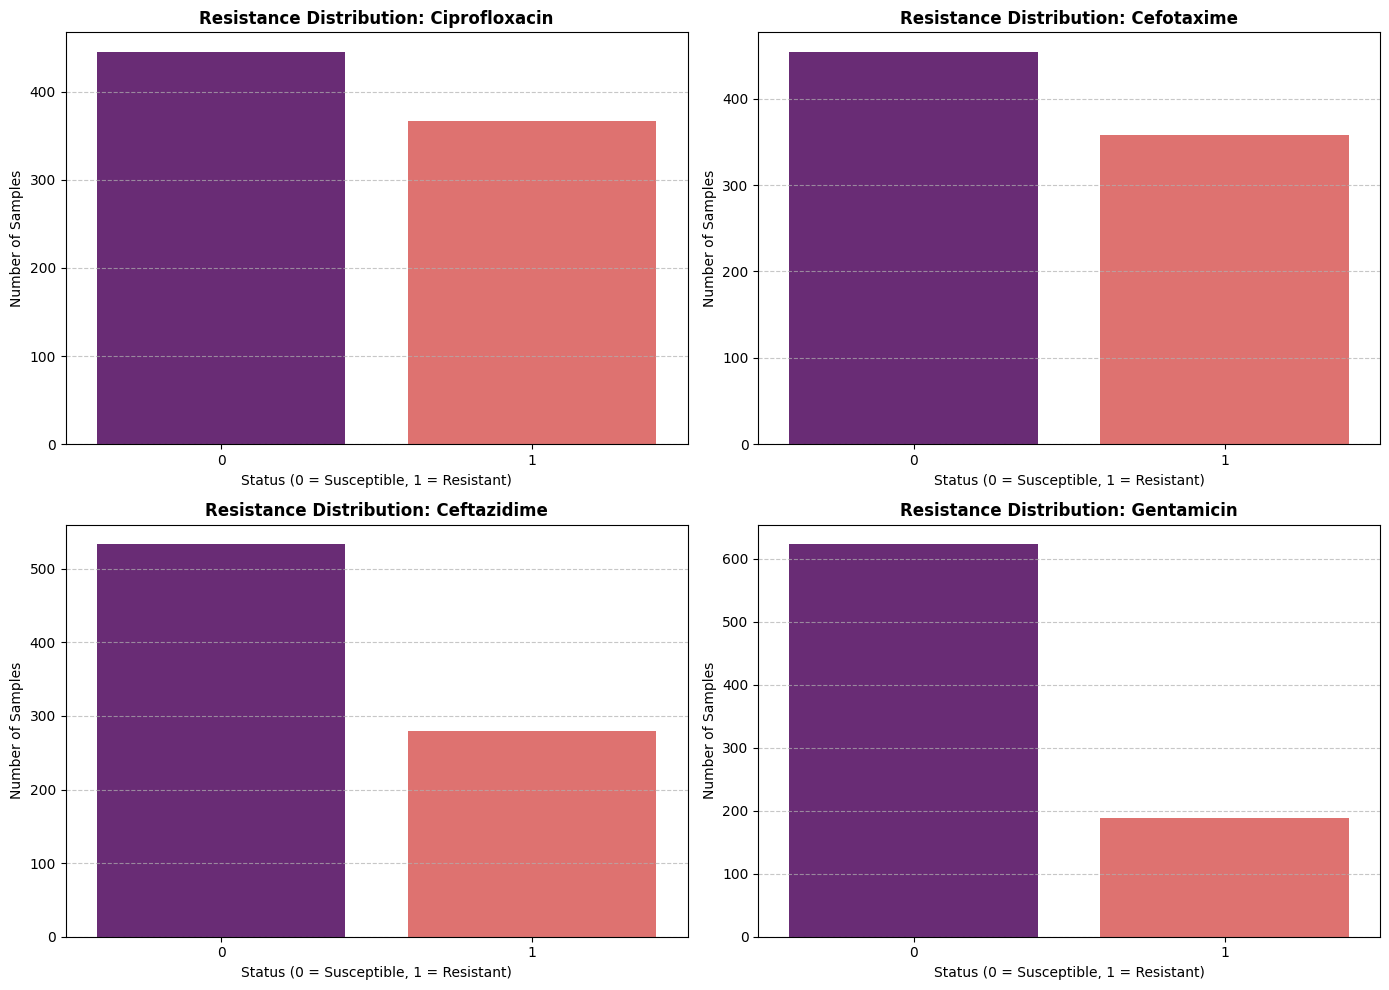

In [ ]:
# Target distribution
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))

# Flattened the axes array for easy iteration
axes_flat = axes.flatten()

for i, drug in enumerate(fullname_antibiotics):
    ax = axes_flat[i]

    sns.countplot(
        x=drug,
        data=metadata_encoded,
        order=[0, 1],
        palette='magma',
        ax=ax
    )

    # Customizing each subplot
    ax.set_title(f'Resistance Distribution: {drug}', fontweight='bold')
    ax.set_xlabel('Status (0 = Susceptible, 1 = Resistant)')
    ax.set_ylabel('Number of Samples')

    # Gridlines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Prevents overlapping titles/labels
fig.tight_layout()
plt.show();


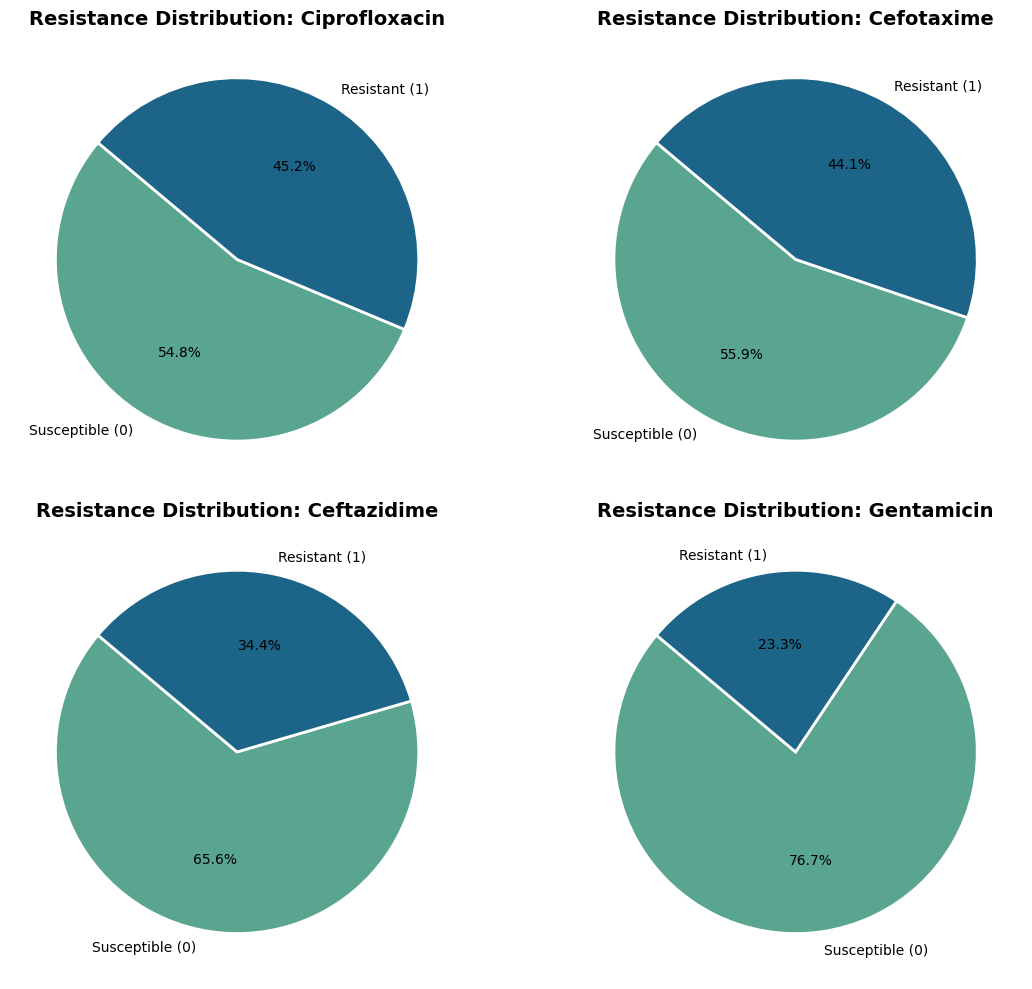

In [ ]:
# Numerical balance overview (percentages)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, drug in enumerate(fullname_antibiotics):
    ax = axes[i]

    # Calculating counts, always index 0,1
    counts = metadata_encoded[drug].value_counts().reindex([0, 1], fill_value=0)

    # Piechart
    ax.pie(
        counts,
        labels=['Susceptible (0)', 'Resistant (1)'],
        autopct='%1.1f%%',
        startangle=140,
        colors=[sns.color_palette("crest")[1], sns.color_palette("crest")[4]],
        wedgeprops={'edgecolor': 'white', 'linewidth': 2}
    )

    # Title per subplot
    ax.set_title(f'Resistance Distribution: {drug}', fontsize=14, fontweight='bold')

fig.tight_layout()
plt.show()

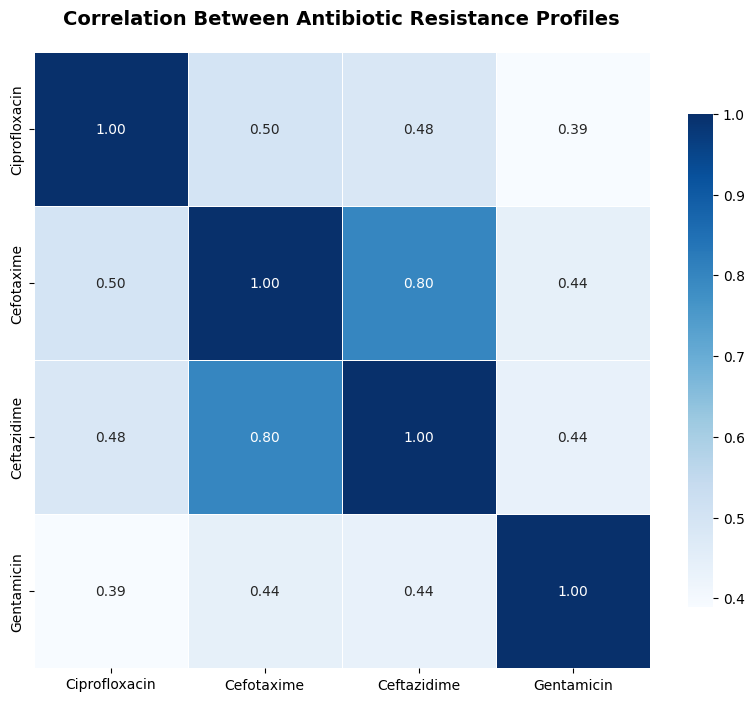

In [ ]:
# Correlation heatmap
# To see if resistance to one antibiotic often coincides with another (multi-drug resistance)
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate the correlation matrix
corr_matrix = metadata_encoded[fullname_antibiotics].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .8},
    ax=ax
)
ax.set_title('Correlation Between Antibiotic Resistance Profiles', fontsize=14, fontweight='bold', pad=20)
plt.show()

# **The *variants* dataset**

In [ ]:
# Loading the dataset
variants = pd.read_csv("/content/variants.csv")

/tmp/ipython-input-3901741873.py:2: DtypeWarning: Columns (735,1713,2406,2499,2653,2664,2665,2785,2978,3185,3664,4019,4101,4343,5062,5118,5807,6837,7073,8155,8207,8751,9686,10773,12068,12296,13416,14010,14803,15524,15614,15690,16036,17592,18141,18820,19093,19420,20520,21699,22188,22410,22925,23111,23178,23403,24229,24828,25299,26216,26502,26793,27932,27966,28068,29694,30095,30132,34396,34600,36114,36125,36336,36373,36473,36948,37418,37463,37526,37676,37984,39247,39478,40775,41110,41195,41645,41824,42203,42315,42454,42532,43410,43419,45948,46475,46757,47540,48508,48691,48925,49033,49108,49384,49434,49436,49819,50058,50922,51028,51066,52178,56157,57103,57280,59190,59436,59537,60189,60643,60817) have mixed types. Specify dtype option on import or set low_memory=False.
  variants = pd.read_csv("/content/variants.csv")


In [ ]:
variants.head()

,SampleID,X393,X588,X747,X759,X774,X966,X1299,X1302,X1407,...,X4639956.3,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3
0,NNRBG-17-0191-1_S1,NaN,A,NaN,T,C,NaN,NaN,NaN,NaN,...,NaN,NaN,T,G,NaN,C,NaN,NaN,C,NaN
1,NNRBG-17-0193-1_S2,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,T,...,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NNRBG-17-0196-1_S3,NaN,A,G,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN
3,NNRBG-17-0198-1_S4,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T,G,NaN,NaN,NaN,NaN,C,A
4,NNRBG-17-0199-1_S5,NaN,NaN,NaN,NaN,C,NaN,C,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN


In [ ]:
variants.shape

(840, 60937)

In [ ]:
# Remove '_run2' from SampleID for rows 813 to 839
variants.loc[813:839, 'SampleID'] = variants.loc[813:839, 'SampleID'].str.replace('_run2', '', regex=False)

In [ ]:
variants.tail(31)

,SampleID,X393,X588,X747,X759,X774,X966,X1299,X1302,X1407,...,X4639956.3,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3
809,H205_D1_L001,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,T,...,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN
810,H206_D2_L001,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,...,NaN,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,A
811,wRBG-17-072-1_X001,N,A,N,N,C,N,N,N,T,...,C,T,N,N,N,C,N,N,N,N
812,wRBG-17-064-1_X002,G,A,G,T,C,C,C,C,T,...,C,T,T,G,A,C,A,C,C,A
813,NNRBG-17-0191-1_S1,G,A,G,T,C,C,C,C,T,...,C,T,T,G,A,C,A,C,C,A
814,NNRBG-17-0193-1_S2,G,A,G,T,C,C,C,C,T,...,C,T,T,G,A,C,A,C,C,A
815,NNRBG-17-0196-1_S3,G,A,G,T,C,C,C,C,T,...,C,T,T,G,A,C,A,C,C,A
816,NNRBG-17-0198-1_S4,N,N,G,T,C,C,C,C,T,...,C,T,T,G,A,C,A,C,C,A
817,NNRBG-17-0199-1_S5,G,A,G,T,C,C,C,C,T,...,C,T,T,G,A,C,A,C,C,A
818,NNRBG-17-0201-1_S6,N,N,G,T,C,C,C,C,T,...,C,T,N,N,G,C,A,C,C,A


In [ ]:
variants.duplicated(subset=['SampleID']).sum()

np.int64(27)

In [ ]:
variants = variants.drop_duplicates(subset=['SampleID'], keep='last')

In [ ]:
variants.isnull().sum().sort_values(ascending = False).head(40)

,0
X3055,2
X3025,2
X4641439.3,2
X393,2
X588,2
X747,2
X1593,2
X774,2
X966,2
X4636297.3,2


## **Preprocessing - Data cleaning**

### **Missing data**

In [ ]:
total_samples = variants.shape[0] * variants.shape[1]
total_missing = variants.isnull().sum().sum()
missing_percentage =  total_missing / total_samples * 100
print("The variants dataset has " + str(total_missing) + " missing values, which is " + str(round(missing_percentage, 2)) + "% of all data")

The variants dataset has 94761 missing values, which is 0.19% of all data


In [ ]:
#Adding a missing row to variants so rows with too much missings can be removed, we do still have to decide a treshold
variants["missing_per_row"] = variants.isnull().sum(axis = 1) / (variants.shape[1] - 1)

In [ ]:
variantsIDIsInMetadata = variants.loc[variants["SampleID"].isin(metadata["Sample_ID"])]
variantsIDIsInMetadata["missing_per_row"].sort_values(ascending = False)

,missing_per_row
809,0.778817
810,0.776273
558,0.000000
559,0.000000
560,0.000000
...,...
300,0.000000
301,0.000000
302,0.000000
303,0.000000


In [ ]:
# Checking for erroneous data
valid_bases = {'A', 'C', 'T', 'G', 'N'}

# Checking only in the loci columns
exclude_cols = ['SampleID	', 'missing_per_row']
loci_columns = [col for col in variants.columns if col not in exclude_cols]

# Find columns with other values
error_log = {}
for col in loci_columns:
    # unique() includes NaN by default
    unique_vals = variants[col].unique()

    # Filter that keeps value only if it is NOT a valid base AND NOT a NaN
    errors = [
        v for v in unique_vals
        if v not in valid_bases and not pd.isna(v)
    ]

    if errors:
        error_log[col] = errors

# Displays results
if error_log:
    print(f"Found {len(error_log)} columns with other than valid base values and NaNs:")

    # Summary of first few errors
    summary_list = []
    for col, errs in list(error_log.items())[:15]:
        summary_list.append({
            'Genomic position': col,
            'Other values': errs,
            'Count': len(errs)
        })

    summary_df = pd.DataFrame(summary_list)
    print(summary_df.to_string(index=False))
else:
    print("No other characters found in the loci columns (ignoring NaNs and valid DNA bases).")

Found 1 columns with other than valid base values and NaNs:
Genomic position                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
error_columns = list(error_log.keys())
print(f"Columns with illegal characters: {error_columns}")

# Visualizes these 2 columns
inspection_df = variants[error_columns].apply(lambda x: x.unique())
print("\nUnique values in flagged columns:")
print(inspection_df)

# A sample of the raw data from these columns (which rows have the errors)
print("\nFirst 10 rows of the flagged columns:")
display(variants[error_columns].head(10))

Columns with illegal characters: ['SampleID']

Unique values in flagged columns:
                SampleID
27          H100_S2_L001
28          H105_S3_L001
29          H108_S5_L001
30          H109_S2_L001
31          H113_S6_L001
..                   ...
835  NNRBG-17-0329-1_S26
836  NNRBG-17-0346-1_S30
837  NNRBG-17-0378-1_S37
838  NNRBG-17-0382-1_S38
839  NNRBG-17-0399-1_S40

[813 rows x 1 columns]

First 10 rows of the flagged columns:


,SampleID
27,H100_S2_L001
28,H105_S3_L001
29,H108_S5_L001
30,H109_S2_L001
31,H113_S6_L001
32,H116_S8_L001
33,H119_S7_L001
34,H122_S4_L001
35,H123_S1_L001
36,H130_S2_L001


### **Merging tables**

In [ ]:
variantsIDIsInMetadata = variantsIDIsInMetadata.rename(columns={'SampleID': 'Sample_ID'})

In [ ]:
MergedVariants = pd.merge(metadata_encoded, variantsIDIsInMetadata, on="Sample_ID", how="right")
MergedVariants

,Sample_ID,Ciprofloxacin,Cefotaxime,Ceftazidime,Gentamicin,X393,X588,X747,X759,X774,...,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3,missing_per_row
0,H100_S2_L001,0,1,0,0,G,A,G,T,C,...,T,T,G,A,C,A,C,C,A,0.0
1,H105_S3_L001,1,1,0,0,G,A,G,T,C,...,T,T,G,A,C,A,C,C,A,0.0
2,H108_S5_L001,0,1,0,0,G,A,G,T,C,...,T,T,G,A,C,A,C,C,A,0.0
3,H109_S2_L001,0,1,0,0,G,A,G,T,C,...,T,T,G,A,C,A,C,C,A,0.0
4,H113_S6_L001,1,1,0,0,N,N,G,T,C,...,T,N,N,G,C,A,C,C,A,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,NNRBG-17-0329-1_S26,0,0,0,0,G,A,G,T,C,...,T,T,G,A,C,A,C,C,A,0.0
804,NNRBG-17-0346-1_S30,1,0,0,0,G,A,G,T,C,...,T,T,G,A,C,A,C,C,A,0.0
805,NNRBG-17-0378-1_S37,1,0,0,1,G,A,G,T,C,...,T,T,G,A,C,A,C,C,A,0.0
806,NNRBG-17-0382-1_S38,0,0,0,0,G,N,N,N,N,...,N,N,N,A,N,N,N,N,N,0.0


In [ ]:
#Example removal with treshold 0.5
variants_before_missing = variants.copy()
MergedVariants = MergedVariants.loc[MergedVariants["missing_per_row"] < 0.5]
MergedVariants["missing_per_row"].sort_values(ascending = False)

,missing_per_row
807,0.0
0,0.0
1,0.0
2,0.0
3,0.0
...,...
9,0.0
10,0.0
11,0.0
12,0.0


In [ ]:
variants_before_missing.loc[variants_before_missing["missing_per_row"] > 0]

,SampleID,X393,X588,X747,X759,X774,X966,X1299,X1302,X1407,...,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3,missing_per_row
809,H205_D1_L001,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,T,...,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.778817
810,H206_D2_L001,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,...,NaN,NaN,G,NaN,NaN,NaN,NaN,NaN,A,0.776273


### **Handling Ns and columns with only unique values**

In [ ]:
# Removing columns with all the same values
UniqueCheck = MergedVariants.nunique()
UniqueCheck = UniqueCheck.loc[UniqueCheck == 1]
UniqueCheck

,0
X194818,1
X727912,1
X2408617,1
X2437095,1
X2505911,1
X2631978,1
X2891097,1
X3537823,1
X3630404,1
X3936852,1


In [ ]:
MergedVariantsN = MergedVariants.drop(columns=UniqueCheck.index)

In [ ]:
MergedVariantsN

,Sample_ID,Ciprofloxacin,Cefotaxime,Ceftazidime,Gentamicin,X393,X588,X747,X759,X774,...,X4639956.3,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3
0,H100_S2_L001,0,1,0,0,G,A,G,T,C,...,C,T,T,G,A,C,A,C,C,A
1,H105_S3_L001,1,1,0,0,G,A,G,T,C,...,C,T,T,G,A,C,A,C,C,A
2,H108_S5_L001,0,1,0,0,G,A,G,T,C,...,C,T,T,G,A,C,A,C,C,A
3,H109_S2_L001,0,1,0,0,G,A,G,T,C,...,C,T,T,G,A,C,A,C,C,A
4,H113_S6_L001,1,1,0,0,N,N,G,T,C,...,C,T,N,N,G,C,A,C,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,NNRBG-17-0329-1_S26,0,0,0,0,G,A,G,T,C,...,C,T,T,G,A,C,A,C,C,A
804,NNRBG-17-0346-1_S30,1,0,0,0,G,A,G,T,C,...,C,T,T,G,A,C,A,C,C,A
805,NNRBG-17-0378-1_S37,1,0,0,1,G,A,G,T,C,...,C,T,T,G,A,C,A,C,C,A
806,NNRBG-17-0382-1_S38,0,0,0,0,G,N,N,N,N,...,N,N,N,N,A,N,N,N,N,N


In [ ]:
MergedVariantsN.isnull().sum().sum()

np.int64(0)

## **Exploratory data analysis**

In [ ]:
# Filtering out the metadata
exclude_cols = ['Sample_ID	', 'missing_per_row']
loci_cols = [
    col for col in MergedVariantsN.columns
    if not any(key in str(col).lower() for key in exclude_cols)
]
df_loci = MergedVariantsN[loci_cols]

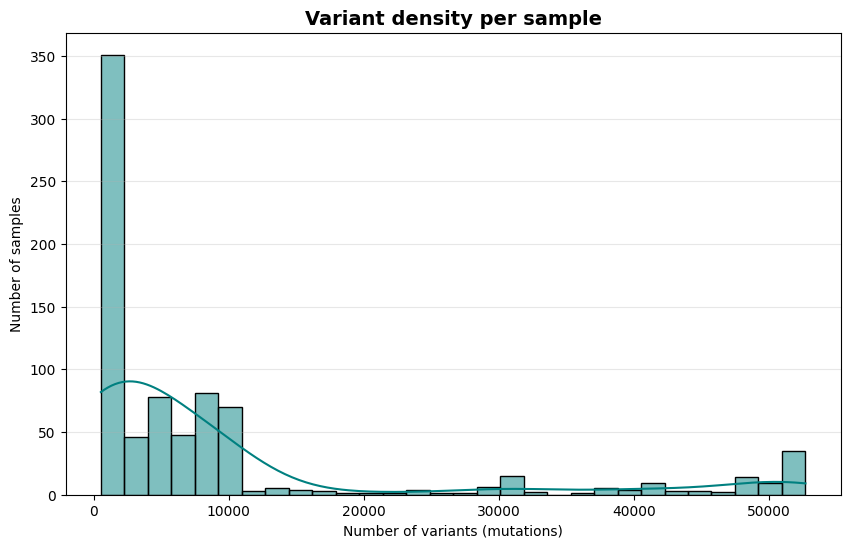

In [ ]:
# Variant density - to see how many mutations on average per sample
# Variant = base that deviates from consensus
def count_variants(row):
    # Mode per column is reference
    consensus = df_loci.mode().iloc[0]
    # Counts where row deviates from the consensus, ignores NaNs and 'N'
    return ((row != consensus) & (row != 'N') & (df_loci.notna().all())).sum()

# Amount of mutations compared to most common base (because of big dataset)
variant_counts_per_sample = (df_loci != df_loci.mode().iloc[0]).sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(variant_counts_per_sample,
             bins=30,
             kde=True,
             ax=ax,
             color='teal'
             )
ax.set_title('Variant density per sample', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of variants (mutations)')
ax.set_ylabel('Number of samples')
ax.grid(axis='y', alpha=0.3)

Calculating MAF for all loci...


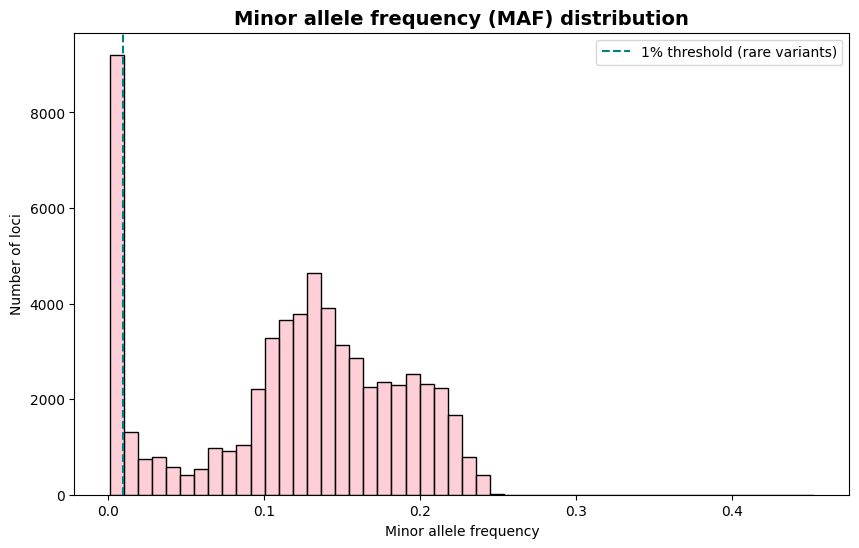

In [ ]:
# Minor allele frequency - how often a specific variant occurs
def calculate_maf(col):
  counts = col.value_counts(normalize=True)
  if len(counts) <= 1:
    return 0  # No variation
  return counts.min() # Frequency of the least common allel

# Apply only once across the columns
print("Calculating MAF for all loci...")
maf_values = df_loci.apply(calculate_maf)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(maf_values[maf_values > 0],
             bins=50,
             kde=False,
             ax=ax,
             color='pink'
             )
ax.set_title('Minor allele frequency (MAF) distribution', fontsize=14, fontweight='bold')
ax.axvline(x=0.01,
           color='teal',
           linestyle='--',
           label='1% threshold (rare variants)'
           )
ax.set_xlabel('Minor allele frequency')
ax.set_ylabel('Number of loci')
ax.legend()

/tmp/ipython-input-75031638.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


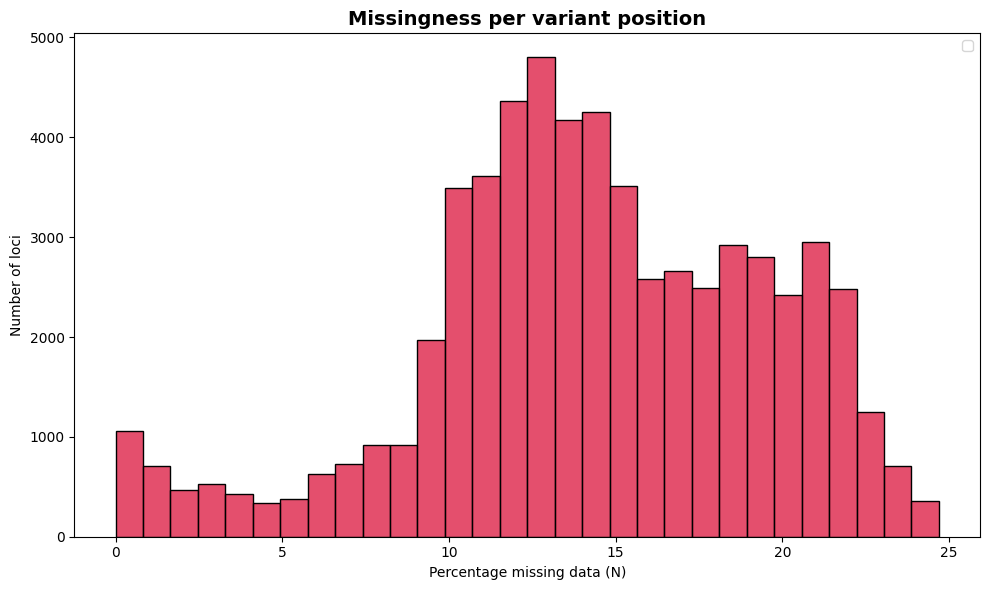

In [ ]:
# Missingness per variant
missingness_per_var = (df_loci.isin(['N']) | df_loci.isna()).mean() * 100

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(missingness_per_var,
             bins=30,
             kde=False,
             ax=ax,
             color='crimson')
ax.set_title('Missingness per variant position', fontsize=14, fontweight='bold')
ax.set_xlabel('Percentage missing data (N)')
ax.set_ylabel('Number of loci')
ax.legend()

plt.tight_layout()
plt.show()

## **X and Y split**

In [ ]:
# Creating the lables for the split
MergedVariantsNoIDNoMissing = MergedVariantsN.drop(columns = ["Sample_ID"])
Outcomes = ["Ciprofloxacin", "Cefotaxime", "Ceftazidime", "Gentamicin"]
X = MergedVariantsNoIDNoMissing.drop(columns = Outcomes)
y = MergedVariantsNoIDNoMissing[Outcomes]

train_X, test_X, train_y, test_y = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify = y,
    random_state=1
    )

train_y_CIP = train_y[Outcomes[0]]
test_y_CIP  = test_y[Outcomes[0]]

train_y_CTX = train_y[Outcomes[1]]
test_y_CTX  = test_y[Outcomes[1]]

train_y_CTZ = train_y[Outcomes[2]]
test_y_CTZ  = test_y[Outcomes[2]]

train_y_GEN = train_y[Outcomes[3]]
test_y_GEN  = test_y[Outcomes[3]]

In [ ]:
X.nunique().sort_values(ascending = False)

,0
X1957146,4
X2409011,4
X2790347.2,4
X3391234,4
X886021.1,4
...,...
X2534983.1,2
X2535046.1,2
X2535165.1,2
X2536064.1,2


## **Encoding**

| Method               | How it works                                                     | Best for                                                      |
| -------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------- |
| **Label Encoding**   | Converts DNA bases to specific numbers: A=1, G=2, C=3, T=4, N=0  | Simple models like Random Forest (RF)                         |
| **One-hot Encoding** | Each base becomes a binary vector (e.g., A = [1, 0, 0, 0])       | Captures more complex relationships, but uses more memory     |
| **FCGR Encoding**    | Converts the sequence into an image-like matrix (resolution 200) | Deep Learning models like Convolutional Neural Networks (CNN) |


### Label Encoding

In [ ]:
LabelDict = {"N": 0, "A": 1, "G": 2, "C": 3, "T": 4}
train_X_label = train_X.replace(LabelDict)
test_X_label = test_X.replace(LabelDict)

/tmp/ipython-input-3202277050.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_X_label = train_X.replace(LabelDict)
/tmp/ipython-input-3202277050.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_X_label = test_X.replace(LabelDict)


In [ ]:
train_X_label

,X393,X588,X747,X759,X774,X966,X1299,X1302,X1407,X1425,...,X4639956.3,X4640785.3,X4640908.3,X4640924.3,X4641031.3,X4641131.3,X4641217.3,X4641296.3,X4641439.3,X4641440.3
403,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1
636,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1
483,2,1,2,4,3,3,3,3,0,0,...,3,4,4,2,1,3,1,3,3,1
615,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1
278,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,2,1,0,0,3,0,3,3,4,0,...,3,4,4,2,1,3,1,0,3,1
369,2,1,0,0,3,0,3,3,4,0,...,3,4,4,2,1,3,1,0,3,1
302,2,1,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1
547,0,0,2,4,3,3,3,3,4,2,...,3,4,4,2,1,3,1,3,3,1


### One-Hot encoding

In [ ]:
# Columns to one-hot encode
cols_to_encode = [c for c in X.columns]
# One-hot encode
train_X_OneHot = pd.get_dummies(train_X, columns=cols_to_encode, dummy_na=False, dtype='uint8')
test_X_OneHot = pd.get_dummies(test_X, columns=cols_to_encode, dummy_na=False, dtype='uint8')


In [ ]:
test_X_OneHot = test_X_OneHot.reindex(columns=train_X_OneHot.columns, fill_value=0)

In [ ]:
train_X_OneHot

,X393_G,X393_N,X588_A,X588_N,X747_G,X747_N,X759_N,X759_T,X774_C,X774_N,...,X4641131.3_N,X4641217.3_A,X4641217.3_G,X4641217.3_N,X4641296.3_C,X4641296.3_N,X4641439.3_C,X4641439.3_N,X4641440.3_A,X4641440.3_N
403,1,0,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
636,1,0,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
483,1,0,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
615,1,0,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
278,1,0,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,1,0,1,0,0,1,1,0,1,0,...,0,1,0,0,0,1,1,0,1,0
369,1,0,1,0,0,1,1,0,1,0,...,0,1,0,0,0,1,1,0,1,0
302,1,0,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
547,0,1,0,1,1,0,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0


### FCGR Encoding

In [ ]:
def fcgr(sequence, resolution=256):
    """
    Compute Frequency Chaos Game Representation (FCGR) for a DNA sequence.
    Returns a 2D numpy array of shape (resolution, resolution).
    """
    grid = np.zeros((resolution, resolution))
    x, y = resolution // 2, resolution // 2
    for base in sequence.upper():
        if base == 'A':
            x = x // 2
            y = y // 2
        elif base == 'C':
            x = x // 2
            y = (y + resolution) // 2
        elif base == 'G':
            x = (x + resolution) // 2
            y = y // 2
        elif base == 'T':
            x = (x + resolution) // 2
            y = (y + resolution) // 2
        else:
            continue  # Skip invalid bases like 'N'
        grid[x, y] += 1
    return grid

# Assuming X is the DataFrame with genomic loci (from previous cells)
# Create sequences for each sample (row)
sequences_train = []
for idx, row in train_X.iterrows():
    seq = ''.join([str(val) for val in row if pd.notna(val) and val != 'N'])
    sequences_train.append(seq)

sequences_test = []
for idx, row in test_X.iterrows():
    seq = ''.join([str(val) for val in row if pd.notna(val) and val != 'N'])
    sequences_test.append(seq)

# Compute FCGR for each sequence
train_X_fcgr = np.array([fcgr(seq) for seq in sequences_train])
test_X_fcgr = np.array([fcgr(seq) for seq in sequences_test])

# X_fcgr is now a 3D array: (n_samples, resolution, resolution)
# For CNN input, may need to add a channel dimension: X_fcgr = X_fcgr[..., np.newaxis]

In [ ]:
train_X_fcgr.shape

(644, 256, 256)

In [ ]:
test_X_fcgr.shape

(162, 256, 256)

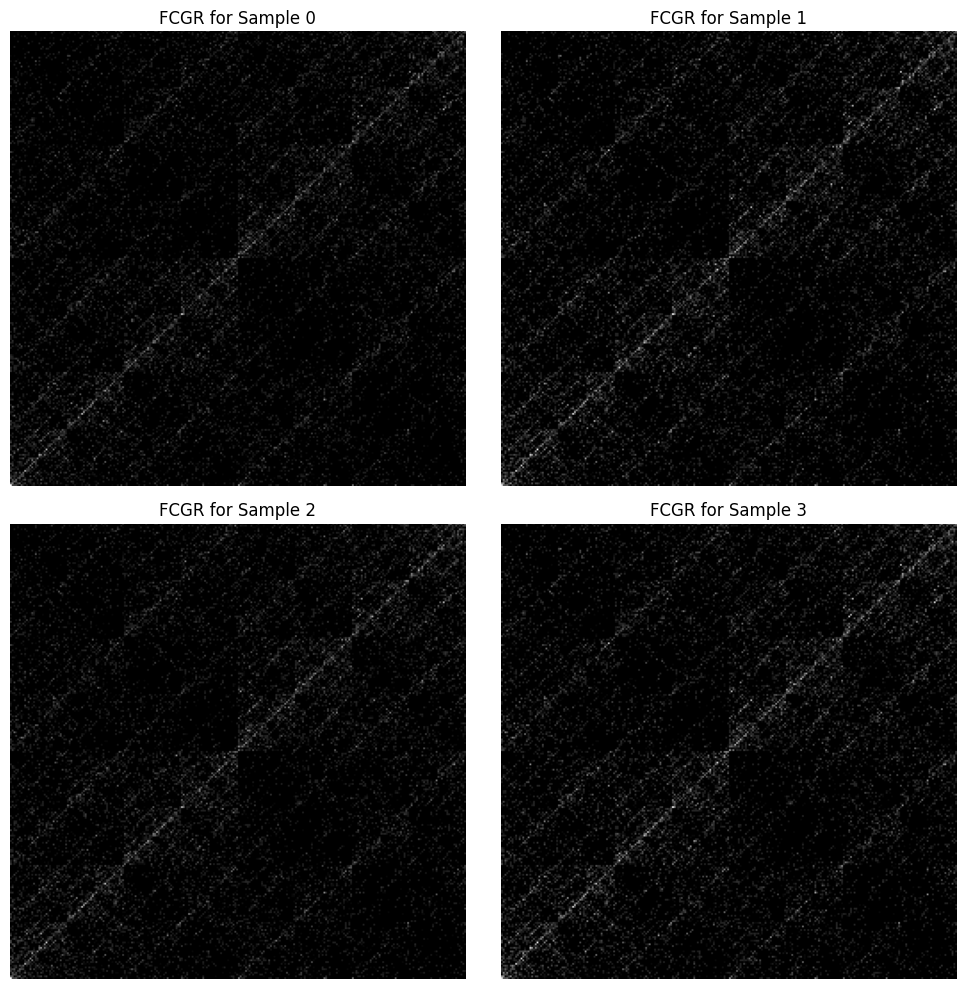

In [ ]:
# Visualize a few FCGR images (e.g., first 4 samples)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    axes[i].imshow(train_X_fcgr[i], cmap='gray')
    axes[i].set_title(f'FCGR for Sample {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# **Machine Learning**

## **Overview of X and y datasets used in the train–test split**


Core data and train–test split

---


| Variable name | Description                                        |
| ------------- | -------------------------------------------------- |
| `X`           | All predictor variables, excluding outcome columns |
| `y`           | All four antibiotic resistance outcomes            |
| `train_X`     | 80% training split of feature matrix               |
| `test_X`      | 20% test split of feature matrix                   |
| `train_y`     | All outcome labels for training set                |
| `test_y`      | All outcome labels for test set                    |



Antibiotic-specific outcomes


---


| Variable name | Description                                    |
| ------------- | ---------------------------------------------- |
| `train_y_CIP` | Ciprofloxacin resistance labels (training set) |
| `test_y_CIP`  | Ciprofloxacin resistance labels (test set)     |
| `train_y_CTX` | Cefotaxime resistance labels (training set)    |
| `test_y_CTX`  | Cefotaxime resistance labels (test set)        |
| `train_y_CTZ` | Ceftazidime resistance labels (training set)   |
| `test_y_CTZ`  | Ceftazidime resistance labels (test set)       |
| `train_y_GEN` | Gentamicin resistance labels (training set)    |
| `test_y_GEN`  | Gentamicin resistance labels (test set)        |


Feature representations / encodings

---

| Variable name    | Description                                |
| ---------------- | ------------------------------------------ |
| `train_X_label`  | Label-encoded training feature matrix      |
| `test_X_label`   | Label-encoded test feature matrix          |
| `train_X_OneHot` | One-hot encoded training feature matrix    |
| `test_X_OneHot`  | One-hot encoded test feature matrix        |
| `train_X_fcgr`   | FCGR representations of training sequences |
| `test_X_fcgr`    | FCGR representations of test sequences     |
